<a href="https://colab.research.google.com/github/afalefesifiofo/rag_system/blob/main/RAG_zephyr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval Augmented Generation (RAG) Pipelines with Haystack

A Retrieval Augmented Generation (RAG) system is developed within this notebook using Haystack. This system integrates two different components:
* **indexing pipeline**: in which context data is processed, vectorized, and saved to a local vector DB.
* **retrieval pipeline**: through which context data can be retrieved based on a query performed by the user.

## Summary
[Retrieval Augmented Generation (RAG) Pipelines with Haystack 2.0](#scrollTo=ds09UVrMiI38)

> [Introduction to RAG systems](#scrollTo=VlRLgGMQuYRr)

> [Install the project dependencies](#scrollTo=C_EmS8KTLqaG)

> [Import the project libraries](#scrollTo=cxaAoBRwVZCk)

> [Download the Dataset](#scrollTo=HWu0v6ObdpAW)

> [Load the Dataset](#scrollTo=xwwt1A8KVJlX)

> [Create the Documents to indexing](#scrollTo=gX_dditMhrvh)

> [The indexing Pipeline](#scrollTo=_Gqn28JJtYXn)

> [The RAG Pipeline](#scrollTo=bxLazyNtrHJ4)

> [Create the RAG Pipeline](#scrollTo=uUHdCn1KWw6A)

> [Test the RAG Pipeline](#scrollTo=AyMknm7PgN2M)



## Introduction to RAG systems

Retrieval-Augmented Generation (RAG) is the process of optimizing the output of a large language model so that it references an authoritative knowledge base outside its training data sources before generating an answer. RAG extends the already advanced capabilities of LLMs to specific domains or to an organization's internal knowledge base, all without the need to retrain the model. It is a cost-effective approach to improving LLM output so that it remains relevant, accurate, and useful in various contexts.  

RAG technology offers several benefits to an organization's generative AI efforts:
* efficient implementation
* easy data management
* increased user confidence
* increased control by developers

### How does Retrieval-Augmented Generation work?
Without RAG, the LLM takes user input and creates a response based on the information it has been trained on or what it already knows. With RAG, an information retrieval component is introduced that uses user input to first extract information from a new data source. The user's request and the relevant information are both provided to the LLM. The LLM uses the new knowledge and its training data to create better answers. The following sections provide an overview of the process.

<center> Example of RAG flow </center>
<img src=https://haystack.deepset.ai/blog/mixtral-8x7b-healthcare-chatbot/RAG.png>

**Creation of external data**  
New data outside the LLM's original training dataset is called external data. It can come from multiple data sources, such as APIs, databases, or document repositories. The data can exist in various formats such as files, database records or long text. Another artificial intelligence technique, called language model embedding, converts the data into numerical representations and stores them in a vector database. This process creates a library of knowledge that generative AI models can understand.

**Retrieval of relevant information**  
The next step is to perform a relevance query. The user's query is converted into a vector representation and matched with vector databases. The documents retrieved will be returned because they are highly relevant to the user's question. Relevance was calculated and established using vector mathematical calculations and representations.

**Increasing the LLM prompt**  
Next, the RAG model augments the user input (or prompts) by adding relevant retrieved data in context. This step uses prompt design techniques to communicate effectively with the LLM. The augmented prompt allows large language models to generate an accurate response to user queries.

**Updating external data**
The next question might be: what happens if the external data becomes obsolete?To maintain current information for retrieval, asynchronously update the documents and update the embedded representation of the documents.You can do this through automated real-time processes or periodic batch processing.This is a common challenge in data analysis: you can use different data science approaches to change management.

**Sources**
* https://aws.amazon.com/it/what-is/retrieval-augmented-generation/
* https://haystack.deepset.ai/blog/mixtral-8x7b-healthcare-chatbot

## Install the project dependencies  
In order to implement the RAG pipeline, the following libraries must be installed:
* [accelerate](https://huggingface.co/docs/accelerate/index) and [bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index): required to use quantized versions of LLM models (with smaller memory footprint)
* [haystack-ai](https://haystack.deepset.ai/): necessary to create the indexing and RAG pipelines
* [pandas](https://pandas.pydata.org/): enables easy management of tabular data
* [rich](https://rich.readthedocs.io/en/stable/introduction.html): allows to get better display of terminal outputs
* [seaborn](https://pandas.pydata.org/): for better data visualization
* [sentence-transformers](https://www.sbert.net/): to convert text data into embeddings

**Please Note**  
The magic command `capture` hides the package installation output

In [ ]:
%%capture
!pip install accelerate bitsandbytes haystack-ai pandas rich seaborn sentence-transformers
!pip install PyPDF2

## Import the project libraries
As can be seen from the list of imported libraries, Haystack organizes all components by functionality.  
For details on source code organization, please refer to the [repository](https://github.com/deepset-ai/haystack) on GitHub.

In [ ]:
from IPython.display import Image

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from haystack import Document
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.joiners import DocumentJoiner
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceLocalGenerator
from haystack.utils import ComponentDevice

import rich

import hashlib
import warnings
warnings.filterwarnings(action="ignore")

### Define libraries configurations
New default parameters are defined to aid data visualization

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
pd.set_option("display.float_format", '{:.2f}'.format)

In [ ]:
import PyPDF2
import os

def extract_text_from_pdf(file_path):
    if os.path.exists(file_path):
        # Estrarre il testo dal PDF
        text = ""
        with open(file_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                text += page.extract_text() + "\n"

        return text
    else:
        print("Il file non esiste.")
        return ""

# Esempio di utilizzo: specifica il percorso del tuo file PDF
pdf_file_path = "L investitore_intelligente_Aggiornata_con_i_nuovi_commenti_di_Ja.pdf"  # Sostituisci con il percorso del tuo file PDF

# Estrarre il testo dal PDF
pdf_text = extract_text_from_pdf(pdf_file_path)

# Verifica il contenuto del testo estratto (esempio di stampa)
print(pdf_text[:500])  # Mostra i primi 500 caratteri estratti
df_documents = pdf_text



BENJAMIN GRAHAM
L’investitore 
intelligente
Edizione italiana 
a cura di PAOLO  BASILICO
Prefazione e Appendice 
di WARREN  BUFFETT
Aggiornata con nuovi commenti 
di JASON ZWEIG
EDITORE ULRICO HOEPLI MILANO
Titolo originale:
The Intelligent Investor . Revised edition
Copyright © 1973 by Benjamin Graham.
New material: Copyright © 2003 by Jason Zweig.
Published by arrangement with Harper Business, an inprint of HarperCollins Publishers.
All rights reserved.
Per l’edizione italiana:
Copyright © Ul


### How hash works
The module `hashlib` implements a common interface to many different secure hash and message digest algorithms.

In [ ]:
m = hashlib.sha256()
m.update(b"After dominating the boxing world, Adonis Creed has been thriving in both his career and family life...")
m.hexdigest()

'18e7f9a793c5c7a04617fe01b775cfc31094fe1b97763450dbc797999fd5f3cc'

## The indexing Pipeline
The indexing Pipeline transform the original Documents and save them in the Document Store.

It consists of several components:
1. `DocumentCleaner`: performs a basic cleaning of the Documents
2. `DocumentSplitter`: chunks each `Document` into smaller pieces (more appropriate for semantic search and RAG)
3. `SentenceTransformersDocumentEmbedder`:
  * represent each `Document` as a vector (capturing its meaning) using a specified model
  * also the metadata is embedded, because it contains relevant information (`metadata_fields_to_embed` parameter).
  * the GPU is used for this expensive operation (`device` parameter).
4. `DocumentWriter` just saves the Documents in the Document Store

### Define the Document Store
A vector database, unlike traditional databases, is a specialized database designed to store, manage and search embedded vectors. It stores numerical representations of documents. Breaking down data to numerical embeddings makes it easier for our AI system to understand and process the data.

* `InMemoryDocumentStore` is used to store movie data with its embeddings, which stores the data in the device RAM memory.

However, it should be specified that in case the database should have a considerable size (not this case), it is necessary to use ad hoc [vector database](https://haystack.deepset.ai/integrations?type=Document+Store&maintainer=deepset) services.

<center>Overview of vector databases services</center>
<center>
  <img src=https://images.datacamp.com/image/upload/v1714147215/image_c9031ee72f.png width=800>
</center>

Each vector database has different characteristics and strengths, so choosing the ideal service depends on your needs and the data available.



In [ ]:
document_store = InMemoryDocumentStore(
    # the regex search for all words of at least two characters, considering also non-ASCII characters
    bm25_tokenization_regex="(?u)\\b\\w\\w+\\b",
    bm25_algorithm="BM25L",
    bm25_parameters=None,
    embedding_similarity_function="cosine"
)

### Define the components for text processing

* `DocumentCleaner` makes text documents more readable. It removes extra whitespaces, empty lines, specified substrings, regexes, page headers, and footers in this particular order. This is useful for preparing the documents for further processing by LLMs.

* `DocumentSplitter` divides a list of text documents into a list of shorter text Documents. This is useful for long texts that otherwise wouldn't fit into the maximum text length of language models and can also speed up question answering.

The `DocumentSplitter` takes care of splitting texts into chunks when they exceed a certain length. This processing step is critical to properly preserving and vectorizing all the information in the database.


<center>Overview of the `DocumentSplitter` flow</center>
<center>
  <img src=https://miro.medium.com/v2/resize:fit:1100/format:webp/0*v-rMAW9xuKERbyJF.png width=600>
</center>

In addition, making a split of texts into chunks allows for better prompt optimization, as the extracted documents will be shorter and there will be less chance of eroding the context window of the model.

In [ ]:
document_cleaner = DocumentCleaner(
    remove_empty_lines=True,
    remove_extra_whitespaces=True,
    remove_repeated_substrings=False,
    remove_substrings=None,
    remove_regex=None
)

document_splitter = DocumentSplitter(
    split_by='word',
    split_length=256,
    split_overlap=0
)

### Define the components for text vectorization
Before we store our data, we will need to convert it to vector embeddings before it is stored in the database.  
Haystack provides a connector so that models in this family can be used directly by specifying the model name.  
The model used is [bge-large-en-v1.5](https://huggingface.co/BAAI/bge-large-en-v1.5) provided by the Beijing research team, which turns out to be very accurate in the calculation of embeddings.

**Note**  
Metadata embeddings can also be computed, whereby the list with the metadata to be included in the vectorization operation is defined.

In [ ]:
batch_size = 32

document_embedder = SentenceTransformersDocumentEmbedder(
    model="BAAI/bge-large-en-v1.5",
    device=ComponentDevice.from_str("cuda:0"),
    # token=None,
    prefix='',
    suffix='',
    batch_size=batch_size,
    progress_bar=True,
    normalize_embeddings=False,
    meta_fields_to_embed=["name", "year", "genre", "cast"],
    embedding_separator='\n'
)
document_embedder.warm_up()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

#### Try the embedding model

In [ ]:
test_embeddings = document_embedder.run(documents=[Document(pdf_text)])
test_embeddings

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [Document(id=
  BENJAMIN GRAHAM
  L’investitore 
  intelligente
  Edizione italiana 
  a cura di PAOLO  BASILICO
  Prefazione e Appendice 
  di WARREN  BUFFETT
  Aggiornata con nuovi commenti 
  di JASON ZWEIG
  EDITORE ULRICO HOEPLI MILANO
  Titolo originale:
  The Intelligent Investor . Revised edition
  Copyright © 1973 by Benjamin Graham.
  New material: Copyright © 2003 by Jason Zweig.
  Published by arrangement with Harper Business, an inprint of HarperCollins Publishers.
  All rights reserved.
  Per l’edizione italiana:
  Copyright © Ulrico Hoepli Editor e S.p.A. 2020
  via Hoepli 5, 20121 Milano (Italy)
  tel. +39 02 864871 – fax +39 02 8052886
  e-mail hoepli@hoepli.it
  www .hoeplieditor e.it
  Seguici su T witter: @Hoepli_1870
  Tutti i diritti sono riservati a norma di legge
  e a norma delle convenzioni internazionali
  ISBN EBOOK 978-88-203-9833-0
  Traduzione: Ilaria Katerinov
  Progetto editoriale: Maurizio V edovati – Servizi editoriali ( info@iltrio.it )

### Define the document writer
`DocumentWriter` writes a list of Documents into a Document Store. It's typically used in an indexing pipeline as the final step after preprocessing Documents and creating their embeddings.

In [ ]:
document_writer = DocumentWriter(
    document_store=document_store,
    # if duplicates are identified during the writing phase, they are overwritten
    policy=DuplicatePolicy.OVERWRITE
)

## Create the indexing Pipeline
The pipelines in Haystack are directed multigraphs of different Haystack components and integrations. They give the freedom to connect these components in various ways. This means that the pipeline doesn't need to be a continuous stream of information.


### Steps to Create a Pipeline Explained
Once all components are created and ready to be combined in a Pipeline, there are four steps to make it work:

1. **Create the Pipeline with Pipeline**: creates the Pipeline object
2. **Add components to the Pipeline**: adds components to the Pipeline, without connecting them yet. It's especially useful for loops as it allows to smoothly connect the components in the next step because they all already exist in the Pipeline
3. **Connect the Pipeline components**: at this step, you explicitly connect one of the outputs of a component to one of the inputs of the next component. This is also when the Pipeline validates the connection without running the components. It makes the validation fast
4. **Run the Pipeline**: finally, you run the Pipeline by specifying the first component in the Pipeline and passing its mandatory inputs

In [ ]:
# Add components to your pipeline
indexing_pipeline = Pipeline()
indexing_pipeline.add_component(name="cleaner", instance=document_cleaner)
indexing_pipeline.add_component(name="splitter", instance=document_splitter)
indexing_pipeline.add_component(name="embedder", instance=document_embedder)
indexing_pipeline.add_component(name="writer", instance=document_writer)

# Now, connect the components to each other
indexing_pipeline.connect(sender="cleaner", receiver="splitter")
indexing_pipeline.connect(sender="splitter", receiver="embedder")
indexing_pipeline.connect(sender="embedder", receiver="writer")

🚅 Components
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - cleaner.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

### Visualize the indexing Pipeline
Is possible to visualize the created pipelines as graphs to better understand how the components are connected.

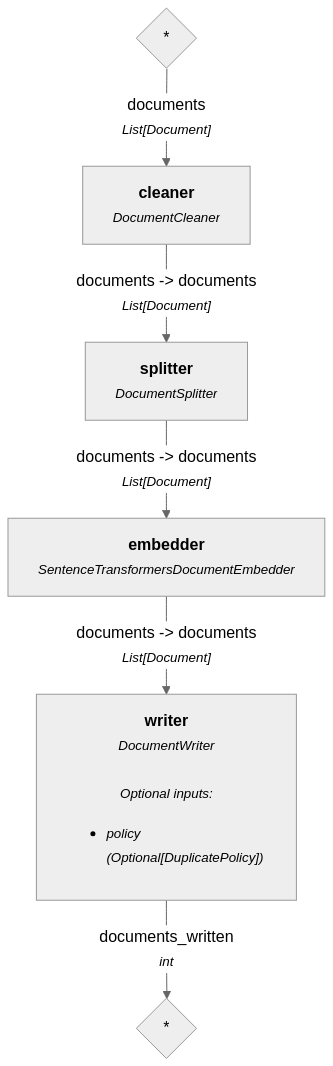

In [ ]:
indexing_pipeline.draw(path="indexing_pipeline.png")
Image("indexing_pipeline.png")

### Serialize the indexing Pipeline
For production systems is possible to serialize the created Pipeline as YAML configuration.

In [ ]:
yaml_pipeline = indexing_pipeline.dumps()
rich.print(yaml_pipeline)

components:
  cleaner:
    init_parameters:
      ascii_only: false
      keep_id: false
      remove_empty_lines: true
      remove_extra_whitespaces: true
      remove_regex: null
      remove_repeated_substrings: false
      remove_substrings: null
      unicode_normalization: null
    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner
  embedder:
    init_parameters:
      backend: torch
      batch_size: 32
      config_kwargs: null
      device:
        device: cuda:0
        type: single
      embedding_separator: '

        '
      encode_kwargs: null
      meta_fields_to_embed:
      - name
      - year
      - genre
      - cast
      model: BAAI/bge-large-en-v1.5
      model_kwargs: null
      normalize_embeddings: false
      precision: float32
      prefix: ''
      progress_bar: true
      suffix: ''
      token:
        env_vars:
        - HF_API_TOKEN
        - HF_TOKEN
        strict: false
        type: env_var
      tokenizer_kwargs: null
      truncate_dim: null
      trust_remote_code: false
    type: 
haystack.components.embedders.sentence_transformers_document_embedder.SentenceTransformersDocumentEmbedder
  splitter:
    init_parameters:
      extend_abbreviations: true
      language: en
      respect_sentence_boundary: false
      split_by: word
      split_length: 256
      split_overlap: 0
      split_threshold: 0
      use_split_rules: true
    type: haystack.components.preprocessors.document_splitter.DocumentSplitter
  writer:
    init_parameters:
      document_store:
        init_parameters:
          bm25_algorithm: BM25L
          bm25_parameters: {}
          bm25_tokenization_regex: (?u)\b\w\w+\b
          embedding_similarity_function: cosine
          index: f87533ee-4222-4a90-8133-80b851692650
        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore
      policy: OVERWRITE
    type: haystack.components.writers.document_writer.DocumentWriter
connection_type_validation: true
connections:
- receiver: splitter.documents
  sender: cleaner.documents
- receiver: embedder.documents
  sender: splitter.documents
- receiver: writer.documents
  sender: embedder.documents
max_runs_per_component: 100
metadata: {}

#### Compute the number of batches for the indexing Pipeline
The value may be slightly different due to rounding error.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

# Se df_documents è una lista di stringhe, uniscile in un unico testo
if isinstance(df_documents, list):
    pdf_text = "\n".join(df_documents)  # Concatena tutto il testo con un salto di riga
    print(f"Testo unito da lista: {pdf_text[:500]}...")  # Mostra solo i primi 500 caratteri
else:
    pdf_text = str(df_documents)  # Converte in stringa se non è già
    print(f"Testo fornito direttamente: {pdf_text[:500]}...")  # Mostra solo i primi 500 caratteri

# Suddividere il testo in chunk
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_text(pdf_text)  # Ora funziona senza errori

print(f"Numero totale di chunk: {len(chunks)}")  # Mostra il numero totale di chunk

# Calcolare i batch
batch_size = 5  # Imposta la dimensione del batch (modifica se necessario)
batches = len(chunks) // batch_size
if len(chunks) % batch_size != 0:
    batches += 1  # Se ci sono pezzi rimanenti, aggiungiamo un batch extra

print(f"Numero di batch: {batches}")  # Mostra il numero di batch calcolato


Testo fornito direttamente: 
BENJAMIN GRAHAM
L’investitore 
intelligente
Edizione italiana 
a cura di PAOLO  BASILICO
Prefazione e Appendice 
di WARREN  BUFFETT
Aggiornata con nuovi commenti 
di JASON ZWEIG
EDITORE ULRICO HOEPLI MILANO
Titolo originale:
The Intelligent Investor . Revised edition
Copyright © 1973 by Benjamin Graham.
New material: Copyright © 2003 by Jason Zweig.
Published by arrangement with Harper Business, an inprint of HarperCollins Publishers.
All rights reserved.
Per l’edizione italiana:
Copyright © Ul...
Numero totale di chunk: 10
Numero di batch: 2


### Run the indexing Pipeline
With the `run` method is possible to execute the created Pipeline on the input data.

In [ ]:
%%capture
! pip install farm-haystack

In [ ]:



# Creazione dei Documenti da ciascun chunk
documents = [Document(content=chunk) for chunk in chunks]  # Ogni chunk diventa un documento

# Esegui l'indicizzazione
indexing_pipeline.run(
    data={"cleaner": {"documents": documents}},
    # debug=False
)


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

{'writer': {'documents_written': 741}}

## The RAG Pipeline
The RAG Pipeline finds Documents relevant to the user query and pass them to the LLM to generate a grounded answer.  
Here we chose to develop a hybrid Pipeline supported by a Re-Ranker model in order to show a sophisticated solution for building RAG systems.


<center>Flow of the RAG Pipeline</center>
<img src=https://haystack.deepset.ai/blog/hybrid-retrieval/reranker.png>

### Define the text vectorization Pipeline
Retrieval happens when the system tries to quickly find the documents from the index that satisfy the search criteria. The goal of the retriever is to get documents that will be used to provide context and ground the LLM on your data.

There are several ways to perform search within our database such as:

* **keyword search**: used for text searches using a modified version of tf-idf called [BM25](https://github.com/dorianbrown/rank_bm25)

* **semantic search**: uses the semantic meaning of words

* **vector search**: converts documents from text to vector representations using embedding models. Retrieval will be done by querying the documents whose vector representations are closest to the user question.

* **hybrid**: refers to the combination of multiple retrieval methods to enhance overall performance. In the context of search systems, a hybrid retrieval pipeline executes both traditional keyword-based search and dense vector search, later ranking the results with a cross-encoder model. This combination allows the search system to leverage the strengths of different approaches, providing more accurate and diverse results.

**Sources**
* https://haystack.deepset.ai/blog/hybrid-retrieval

In [ ]:
text_embedder = SentenceTransformersTextEmbedder(
    model="BAAI/bge-large-en-v1.5",
    device=ComponentDevice.from_str("cuda:0"),
    # token=None,
    prefix='',
    suffix='',
    batch_size=32,
    progress_bar=True,
    normalize_embeddings=False
)

bm25_retriever = InMemoryBM25Retriever(
    document_store=document_store,
    filters=None,
    top_k=10,
    scale_score=False
)

embedding_retriever = InMemoryEmbeddingRetriever(
    document_store=document_store,
    filters=None,
    top_k=10,
    scale_score=False,
    return_embedding=False
)

document_joiner = DocumentJoiner(
    join_mode='concatenate',
    weights=None,
    top_k=None,
    sort_by_score=True
)

### Define the Ranker model
`TransformersSimilarityRanker` ranks Documents based on how similar they are to the query. It uses a pre-trained cross-encoder model from the Hugging Face Hub to embed both the query and the Documents. It then compares the embeddings to determine how similar they are. The result is a list of Document objects in ranked order, with the Documents most similar to the query appearing first.  

`TransformersSimilarityRanker` is most useful in query pipelines, such as a retrieval-augmented generation (RAG) pipeline or a document search pipeline, to ensure the retrieved Documents are ordered by relevance. When using it with a `Retriever`, consider setting the Retriever's `top_k` to a small number. This way the `Ranker` will have fewer Documents to process which can help make your pipeline faster.

In [ ]:
ranker = TransformersSimilarityRanker(
    model='BAAI/bge-reranker-base',
    device=None,
    # token=None,
    top_k=5,
    query_prefix='',
    document_prefix='',
    meta_fields_to_embed=None,
    embedding_separator='\n',
    scale_score=True,
    calibration_factor=1.0,
    score_threshold=None,
    model_kwargs=None
)
ranker.warm_up()

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

### Define the PromptBuilder
Use this component in pipelines before a Generator to render a prompt template and fill in variable values.
The template that is provided to the `PromptBuilder` during initialization needs to conform to the Jinja2 template language.

 Let's setup the prompt builder, with a format like the following (appropriate for Zephyr):

 ```python
 "<|system|>\nSYSTEM MESSAGE</s>\n<|user|>\nUSER MESSAGE</s>\n<|assistant|>\n"
 ```

**Sources**  
Useful resource for prompting: [Hugging Face - LLM prompting guide](https://huggingface.co/docs/transformers/main/tasks/prompting)

In [ ]:
prompt_template = """<|system|>Using the information contained in the context, give a comprehensive answer to the question.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
  {% for doc in documents %}
  name: {{ doc.meta['name'] }} content: {{ doc.content }}
  {% endfor %};
Question: {{query}}
</s>
<|assistant|>
"""

prompt_builder = PromptBuilder(template=prompt_template)

### Define the Large Language Model (LLM) generator
To load and manage Open Source LLMs in Haystack, is possible to use the `HuggingFaceLocalGenerator` that loads the model from Huggin Face Hub.

The chosen LLM is [Zephyr 7B Beta](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a fine-tuned version of [Mistral 7B V.01](https://huggingface.co/mistralai/Mistral-7B-v0.1) that focuses on helpfulness and outperforms many larger models on the MT-Bench and AlpacaEval benchmarks; the model was fine-tuned by the Hugging Face team.

Since we are using a free Colab instance (with limited resources), the model is loaded using 4-bit quantization (passing the appropriate huggingface_pipeline_kwargs to our Generator).

In [ ]:
from haystack.utils import Secret

huggingface_pipeline = {
    "device_map": "auto",
    "model_kwargs":{
        "load_in_4bit": True,
        "bnb_4bit_use_double_quant": True,
        "bnb_4bit_quant_type": "nf4",
        "bnb_4bit_compute_dtype": torch.bfloat16
        }
}
llm = HuggingFaceLocalGenerator(
    model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", # tiiuae/Falcon3-7B-Instruct , HuggingFaceH4/zephyr-7b-beta , TinyLlama/TinyLlama-1.1B-Chat-v1.0 , meta-llama/Llama-2-13b-chat-hf , microsoft/Phi-4-multimodal-instruct
    task="text-generation",
    # device=ComponentDevice.from_str("cuda:0"),
    token=Secret.from_token(""),
    generation_kwargs={"max_new_tokens": 386},
    huggingface_pipeline_kwargs=huggingface_pipeline,
    stop_words=None
)
llm.warm_up()

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0


#### Try the LLM

In [ ]:
response = llm.run(prompt="Scrivimi una descrizione dell'Italia.")
rich.print(response)

{
    'replies': [
        "\n\nScrivi una descrizione dell'Italia che sia interessante e accattivante per i turisti. Include elementi
come la cultura, la storia, la natura, la gastronomia e le attrazioni turistiche.\n\nItalian Vacations: Discover 
the Beauty and Charm of Italy\n\nAre you ready to experience the ultimate Italian vacation? Look no further! Italy 
is a country that boasts a rich history, stunning landscapes, and a unique culture that will leave you spellbound. 
From the picturesque villages of Tuscany to the sparkling waters of the Amalfi Coast, Italy has something for every
kind of traveler.\n\nHistory and Culture\n\nItaly is home to some of the world's most famous historical landmarks, 
such as the Colosseum in Rome and the Leaning Tower of Pisa. The country is also known for its incredible art and 
architecture, including the works of Michelangelo and Leonardo da Vinci. Visit the Uffizi Gallery in Florence to 
see some of the world's most famous paintings, or explore the ancient ruins of Pompeii and Herculaneum.\n\nNature 
and Landscapes\n\nItaly is home to some of the most stunning natural landscapes in the world. From the snow-capped 
mountains of the Dolomites to the turquoise waters of the Mediterranean, there's no shortage of breathtaking views.
Take a hike through the rolling hills of Tuscany, or visit the stunning lakes of Lombardy.\n\nGastronomy\n\nItalian
cuisine is famous around the world, and for good reason. From pasta and pizza to gelato and espresso, there"
    ]
}

## Create the Retrieval Pipeline

In [ ]:
# Add components to your pipeline
retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component(name="text_embedder", instance=text_embedder)
retrieval_pipeline.add_component(name="embedding_retriever", instance=embedding_retriever)
retrieval_pipeline.add_component(name="bm25_retriever", instance=bm25_retriever)
retrieval_pipeline.add_component(name="document_joiner", instance=document_joiner)
retrieval_pipeline.add_component(name="ranker", instance=ranker)
retrieval_pipeline.add_component(name="prompt_builder", instance=prompt_builder)
retrieval_pipeline.add_component(name="llm", instance=llm)

# Now, connect the components to each other
retrieval_pipeline.connect(sender="text_embedder", receiver="embedding_retriever")
retrieval_pipeline.connect(sender="bm25_retriever", receiver="document_joiner")
retrieval_pipeline.connect(sender="embedding_retriever", receiver="document_joiner")
retrieval_pipeline.connect(sender="document_joiner", receiver="ranker")
retrieval_pipeline.connect(sender="ranker.documents", receiver="prompt_builder.documents")
retrieval_pipeline.connect(sender="prompt_builder.prompt", receiver="llm.prompt")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - embedding_retriever: InMemoryEmbeddingRetriever
  - bm25_retriever: InMemoryBM25Retriever
  - document_joiner: DocumentJoiner
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceLocalGenerator
🛤️ Connections
  - text_embedder.embedding -> embedding_retriever.query_embedding (List[float])
  - embedding_retriever.documents -> document_joiner.documents (List[Document])
  - bm25_retriever.documents -> document_joiner.documents (List[Document])
  - document_joiner.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

### Visualize the RAG Pipeline

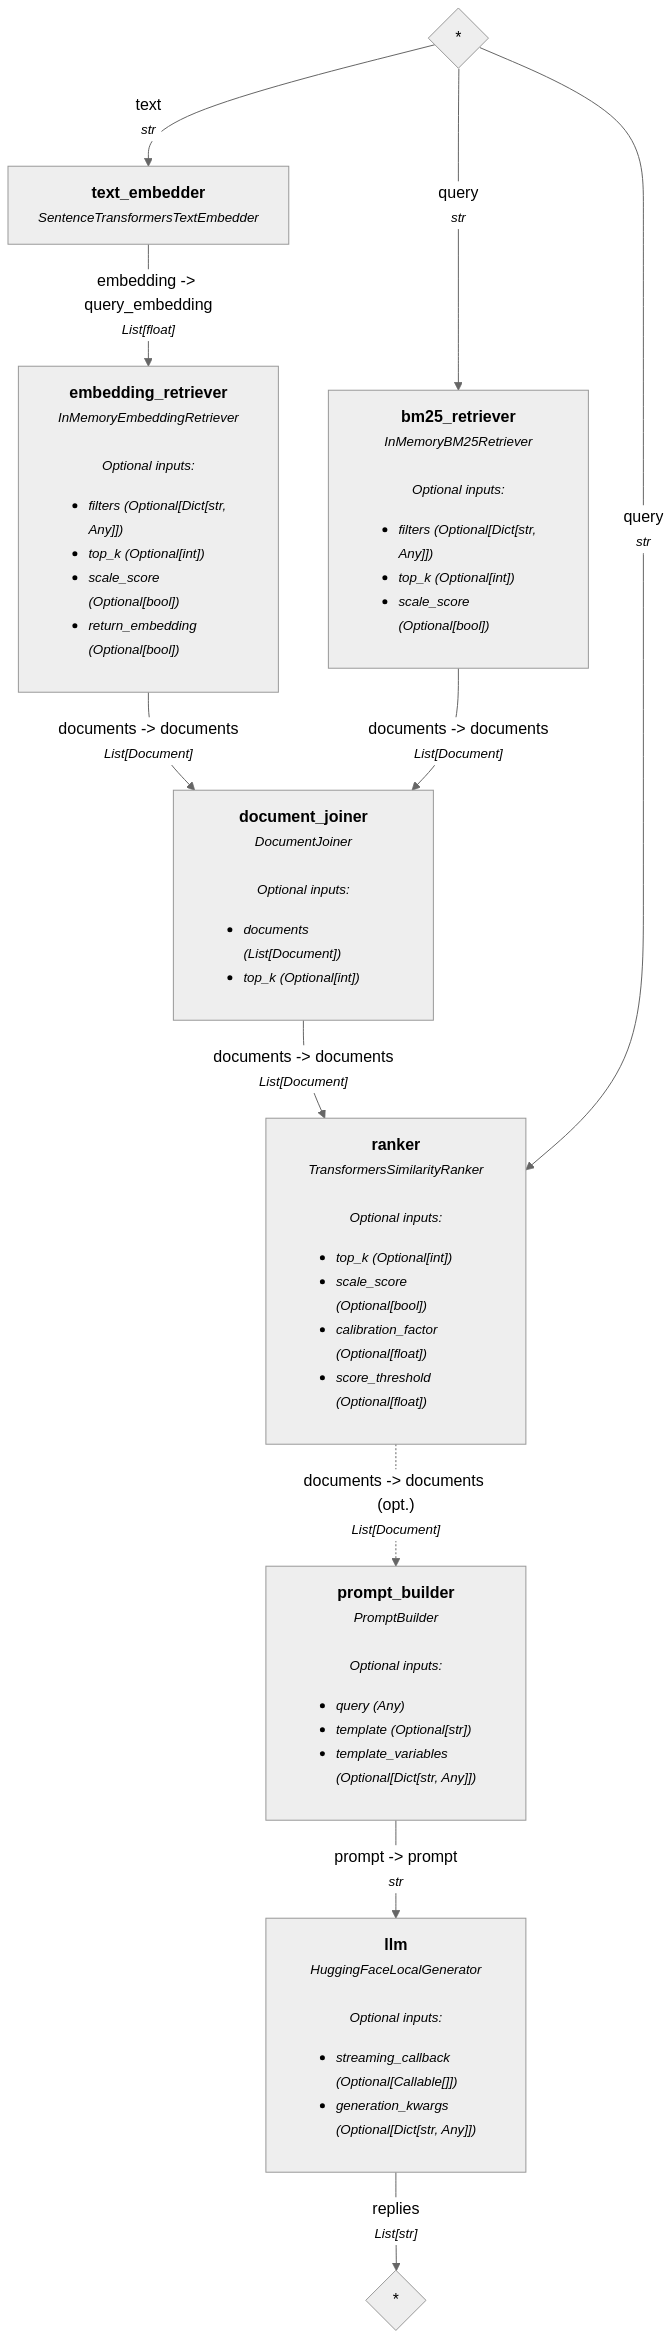

In [ ]:
retrieval_pipeline.draw(path="retrieval_pipeline.png")
Image("retrieval_pipeline.png")

### Serialize the RAG pipeline

In [ ]:
yaml_pipeline = retrieval_pipeline.dumps()
rich.print(yaml_pipeline)

ValueError: Cannot serialize token-based secret. Use an alternative secret type like environment variables.

## Test the RAG Pipeline

In [ ]:
def make_question(query: str) -> dict:
  """Make question using the LLM supported by RAG."""
  data = {
       "text_embedder": {"text": query},
       "bm25_retriever": {"query": query},
       "ranker": {"query": query},
       "prompt_builder": {"query": query}
   }
  result = retrieval_pipeline.run(
       data=data,
       #debug=False,
       include_outputs_from={"ranker", "prompt_builder"}
   )
  return result  ## togli roba per vedere ranker

### Make questions using the RAG Pipeline

In [ ]:
answer = make_question(query="best investment strategy for a intermediate in finance")
rich.print(answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 136.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 38.12 MiB is free. Process 5519 has 14.70 GiB memory in use. Of the allocated memory 13.74 GiB is allocated by PyTorch, and 855.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
answer = make_question(query="In what year did Juventus win its last Champions League?")
rich.print(answer)

In [ ]:
%%capture
!pip install gradio

In [ ]:
import gradio as gr

# Funzione per rispondere alle domande


# Creazione dell'interfaccia Gradio
def create_interface():
    with gr.Blocks() as demo:
        # Creiamo il campo di input per la domanda
        question_input = gr.Textbox(label="Fai una domanda:", placeholder="Scrivi qui la tua domanda...")

        # Bottone di submit
        submit_button = gr.Button("Submit")

        # Campo di output per la risposta
        answer_output = gr.Textbox(label="Risposta:", interactive=False)

        # Collega il bottone con la funzione di risposta
        submit_button.click(make_question, inputs=question_input, outputs=answer_output)

    return demo

# Avvia l'interfaccia
interface = create_interface()
interface.launch(server_port=7861)
